<a href="https://colab.research.google.com/github/majidsh97/AE/blob/main/AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.5 MB/s eta 0:00:00


In [113]:
import datasets
from torchsummary import summary
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
"""

lazwRow?
custom collaborate function

"""

data = datasets.load_dataset('fashion_mnist')
batch_size = 256


train = data['train'].select(range(1024))
test_data = data['test']


data_transform=  transforms.Compose([
    #transforms.ToPILImage(),
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: x/255.0)

])
def custom_collate_fn(batch):
    images = [data_transform(x['image']) for x in batch]
    labels = torch.tensor([x['label'] for x in batch])
    return torch.stack(images).cuda(), labels.cuda()

train_loader = DataLoader(train,batch_size,True,collate_fn=custom_collate_fn)


for image,label in train_loader:
  print(image.shape)
  print(image.max())
  print(image.min())
  break



torch.Size([256, 1, 28, 28])
tensor(1., device='cuda:0')
tensor(0., device='cuda:0')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 14, 14]           1,280
              ReLU-2          [-1, 128, 14, 14]               0
            Conv2d-3            [-1, 256, 7, 7]         295,168
              ReLU-4            [-1, 256, 7, 7]               0
           Flatten-5                [-1, 12544]               0
            Linear-6                  [-1, 256]       3,211,520
            Linear-7                   [-1, 10]           2,570
            Linear-8                  [-1, 256]           2,816
            Linear-9                [-1, 12544]       3,223,808
        Unflatten-10            [-1, 256, 7, 7]               0
  ConvTranspose2d-11          [-1, 128, 14, 14]         295,040
             ReLU-12          [-1, 128, 14, 14]               0
  ConvTranspose2d-13            [-1, 1, 28, 28]           1,153
          Sigmoid-14            [-1, 1,

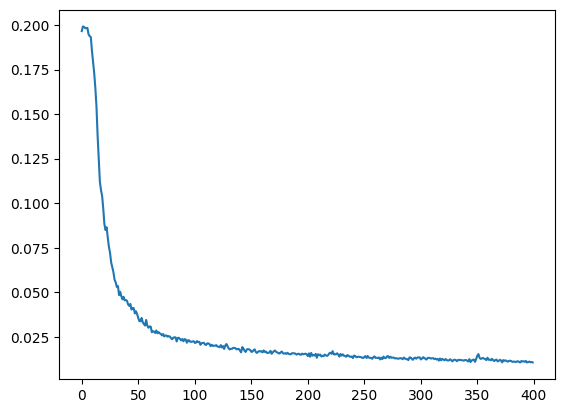

In [153]:
from torch.nn import Conv2d,ReLU,Linear,ConvTranspose2d,LeakyReLU,Tanh,Flatten,Unflatten,Sigmoid,AdaptiveAvgPool2d

mse = torch.nn.MSELoss()
lr = 1e-3*3
f=128
pad=1
encoder_decoder = torch.nn.Sequential(
    Conv2d(1,f,3,2,pad),
    ReLU(),
    Conv2d(f,2*f,3,2,pad),
    ReLU(),
    #AdaptiveAvgPool2d((1,1)),
    Flatten(),
    Linear(2*f*7*7,256),
    Linear(256,10),
    Linear(10,256),
    Linear(256,2*f*7*7),
    Unflatten(1,(2*f,7,7)),
    ConvTranspose2d(2*f,f,3,2,pad,1),
    ReLU(),
    ConvTranspose2d(f,1,3,2,pad,1),
    Sigmoid()
    #Tanh()

).cuda()
summary(encoder_decoder,(1,28,28),device="cuda")
optim = torch.optim.RAdam(encoder_decoder.parameters(),lr,weight_decay=1e-5)

def step(x,y)->torch.Tensor:
    optim.zero_grad()
    output = encoder_decoder.forward(x)
    loss = mse(output,y)
    loss.backward()
    optim.step()
    return loss
    pass

train_loss = []
for epoch in range(100):
    for image,label in train_loader:
        #print(image.shape)
        #print(label.shape)
        #noise = torch.normal(0,1,size=(image.shape[0],1,28,28)).cuda()
        loss = step(image,image)
        #print(loss)
        train_loss.append(loss.cpu().detach().numpy())
        #break
        pass
    print(train_loss[-1])

plt.plot(train_loss)

torch.Size([12, 28, 28, 1])


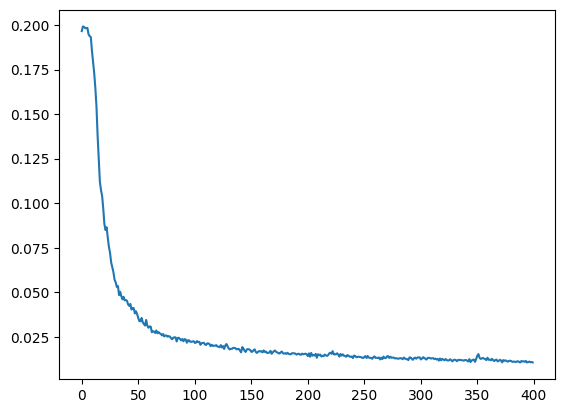

<Figure size 100x100 with 0 Axes>

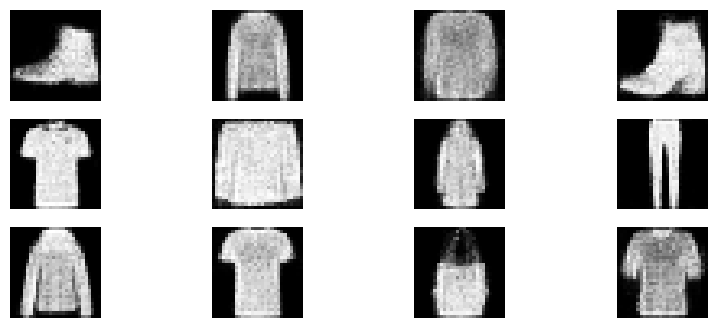

<Figure size 100x100 with 0 Axes>

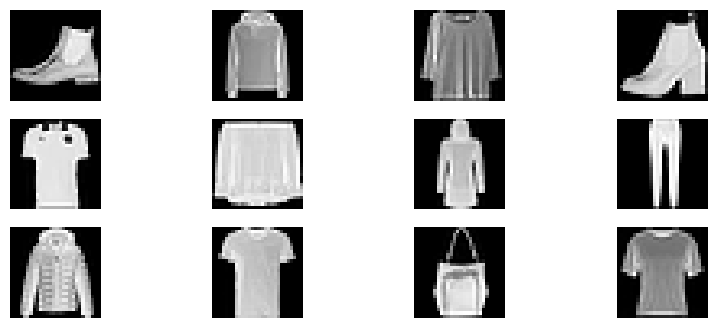

In [154]:
plt.plot(train_loss)

def show_preds(input,image=None):
    preds = input
    if image==None:
        preds:torch.Tensor= encoder_decoder(input)
        preds =  preds.moveaxis(1,-1)
        print(preds.shape)
        preds=preds.cpu().detach().numpy()
    plt.figure(figsize=(1,1))
    fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(10, 4))
    axs = axs.flatten()

    for i in range(preds.shape[0]):
        ax = axs[i]
        ax.imshow(preds[i],cmap='gray',interpolation='none')
        ax.axis('off')
    plt.show()

#noise = torch.normal(0,1,size=(12,1,28,28)).cuda()
#show_preds(noise)

for image,label in train_loader:
    show_preds(image[:12])
    show_preds(image[:12].cpu().moveaxis(1,-1),True)
    break


torch.Size([12, 28, 28, 1])


<Figure size 100x100 with 0 Axes>

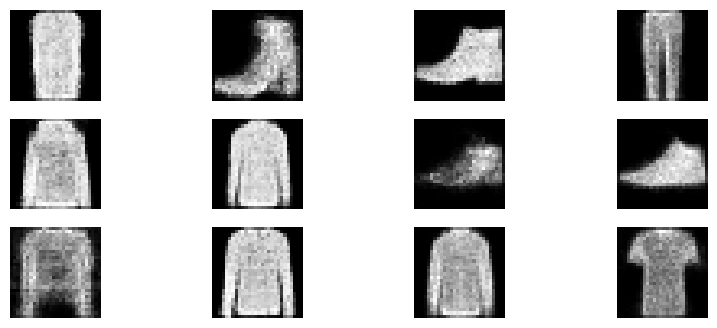

<Figure size 100x100 with 0 Axes>

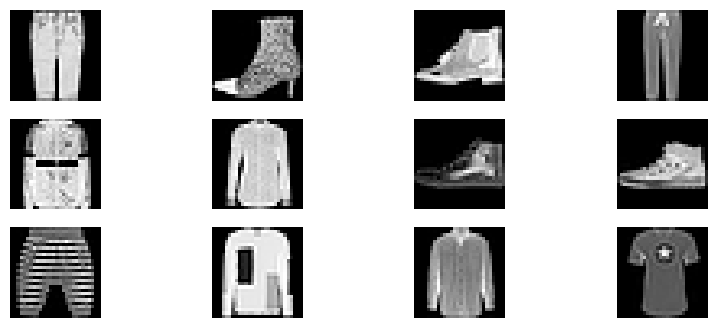

In [155]:
import torch.utils
import torch.utils.data


#test_data = test
sampler = torch.utils.data.RandomSampler(test_data,num_samples=1000)
test_loader = DataLoader(test_data,1000,collate_fn=custom_collate_fn,sampler=sampler)

image,lable = next(iter(test_loader))
show_preds(image[:12])
show_preds(image[:12].cpu().moveaxis(1,-1),True)




<Figure size 200x200 with 0 Axes>

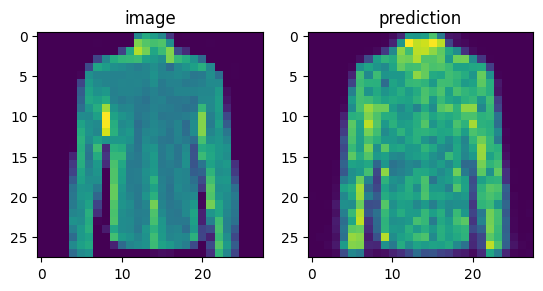

torch.Size([1000, 10])
torch.Size([1000])


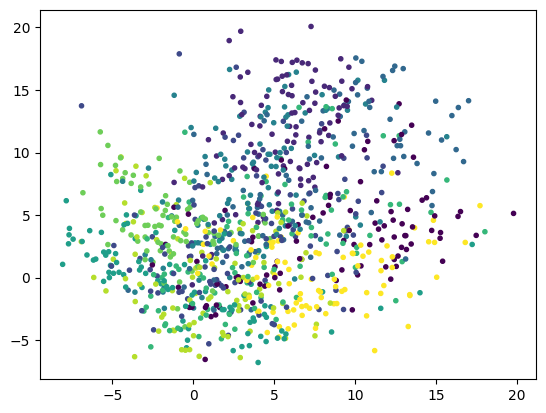

In [156]:
latent=0
def f(m,input,output):
    global latent
    latent=output

encoder_decoder[6].register_forward_hook(f)

image,label = next(iter(test_loader))
pred = encoder_decoder.forward(image)[0]
#print(pred.shape)
plt.figure(figsize=(2,2))
fig,axs =plt.subplots(1,2)
axs[0].imshow(image[0].cpu().moveaxis(0,-1).numpy())
axs[0].set_title('image')
axs[1].imshow(pred.cpu().detach().moveaxis(0,-1).numpy())
axs[1].set_title('prediction')
plt.show()

latent=latent.detach().cpu()
t = latent
print(t.shape)
print(label.cpu().shape)
plt.scatter(t[:,0],t[:,1],c=label.cpu(),marker='.')




<H1>Notes</H1>
normalization have huge imapact accidentally divide 255.0 and it wouldnt generate good samples